### Try different thresholds

### Hyperparameter optimization (HPO)

In [101]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

### You can spin up multiple instances to do hyperparameter optimization in parallel

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have a limit set for these instances
                                    instance_type=instance_type, 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 1000, scaling_type='Linear'),
                         'eta': ContinuousParameter(0.1, 0.5, scaling_type='Linear'),
                         'min_child_weight': ContinuousParameter(3, 10, scaling_type='Linear'),
                         'subsample': ContinuousParameter(0.5, 1),
                         'num_round': IntegerParameter(10,150)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget and available time.
                            max_parallel_jobs=1)

In [102]:
tuner.fit(inputs=data_channels)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-230614-0832


.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


In [103]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [104]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name
print(f'tuning job name:{tuning_job_name}')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
best_training_job = tuning_job_result['BestTrainingJob']
best_training_job_name = best_training_job['TrainingJobName']
print(f"best training job: {best_training_job_name}")

best_estimator = tuner.best_estimator()

tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
tuner_df.head()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


tuning job name:sagemaker-xgboost-230614-0832
best training job: sagemaker-xgboost-230614-0832-004-067096ed

2023-06-14 08:56:43 Starting - Found matching resource for reuse
2023-06-14 08:56:43 Downloading - Downloading input data
2023-06-14 08:56:43 Training - Training image download completed. Training in progress.
2023-06-14 08:56:43 Uploading - Uploading generated training model
2023-06-14 08:56:43 Completed - Resource reused by training job: sagemaker-xgboost-230614-0832-005-94eedb2b


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,342.717258,0.476374,7.402589,27.0,0.717950,sagemaker-xgboost-230614-0832-010-65f6cb3c,Completed,0.71425,2023-06-14 09:22:49+00:00,2023-06-14 09:24:41+00:00,112.0
1,444.129002,0.102858,5.244386,141.0,0.801704,sagemaker-xgboost-230614-0832-009-7adbd512,Completed,0.71685,2023-06-14 09:15:28+00:00,2023-06-14 09:22:07+00:00,399.0
2,947.813502,0.460997,6.031434,103.0,0.837927,sagemaker-xgboost-230614-0832-008-d3e2d74b,Completed,0.71178,2023-06-14 09:11:05+00:00,2023-06-14 09:14:38+00:00,213.0
3,823.142715,0.225853,6.975455,65.0,0.571492,sagemaker-xgboost-230614-0832-007-03b00a74,Completed,0.70866,2023-06-14 09:07:16+00:00,2023-06-14 09:10:48+00:00,212.0
4,737.200683,0.336504,3.914426,56.0,0.979797,sagemaker-xgboost-230614-0832-006-48a4026a,Completed,0.71549,2023-06-14 09:04:08+00:00,2023-06-14 09:06:55+00:00,167.0


Use the estimator `best_estimator` and train it by using the data. 

**Tip:** See the previous XGBoost estimator fit function.

In [106]:
best_estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-06-14-09-26-31-880


2023-06-14 09:26:31 Starting - Starting the training job......
2023-06-14 09:27:11 Starting - Preparing the instances for training......
2023-06-14 09:28:31 Downloading - Downloading input data......
2023-06-14 09:29:06 Training - Downloading the training image...
2023-06-14 09:29:47 Training - Training image download completed. Training in progress..[2023-06-14 09:30:03.693 ip-10-0-105-15.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO

Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [107]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_estimator.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-06-14-09-39-31-895
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-06-14-09-39-32-594


..................................[2023-06-14:09:45:18:INFO] No GPUs detected (normal if no gpus installed)
[2023-06-14:09:45:18:INFO] No GPUs detected (normal if no gpus installed)
[2023-06-14:09:45:18:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-06-14 09:45:19 +0000] [19] [INFO] Starting g

In [108]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['target'])
test_labels = test.iloc[:,0]

Get the predicted target and test labels.

In [109]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

     target
0  0.100730
1  0.076937
2  0.255596
3  0.272046
4  0.444532
   target
0       0
1       0
2       0
3       0
4       0


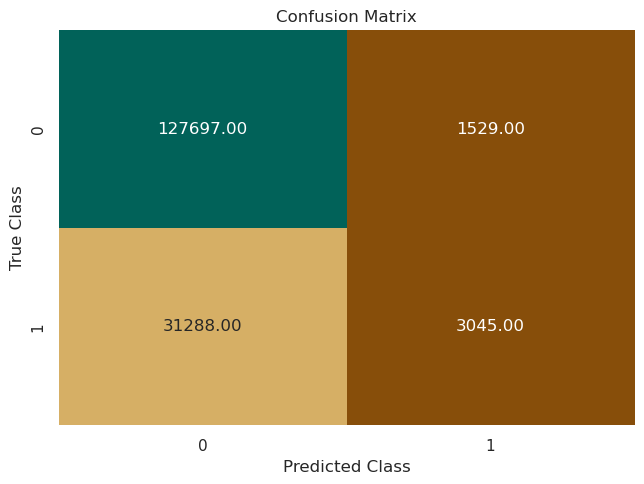

In [110]:
plot_confusion_matrix(test_labels , target_predicted)

Sensitivity or TPR:  8.86901814580724 %
Specificity or TNR:  98.81680157243899 %
Precision:  66.57192829033669 %
Negative Predictive Value:  80.32015598955876 %
False Positive Rate:  1.1831984275610172 %
False Negative Rate:  91.13098185419275 %
False Discovery Rate:  33.428071709663314 %
Accuracy:  79.93568070237652 %
Validation AUC 0.5384290985912312
Figure(640x480)


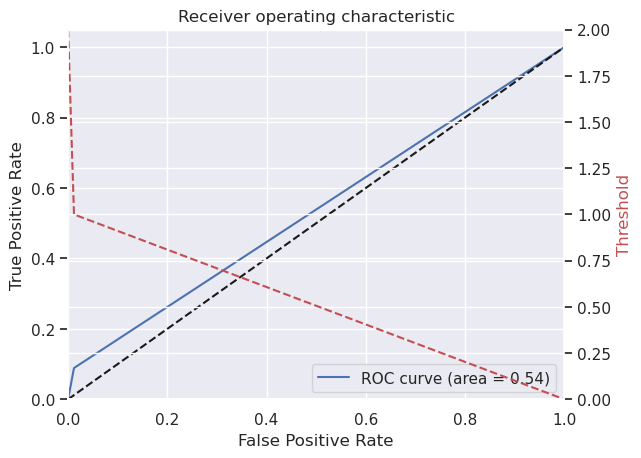

<Figure size 640x480 with 0 Axes>

In [111]:
plot_roc(test_labels, target_predicted)